In [135]:
import torch
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchsummary
import torchsummary
!pip install torchmetrics
import torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Carga de datos

In [136]:
class SinteticDataset(torch.utils.data.Dataset):
    def __init__(self):
      self.x = np.linspace(-5, 5, 10000).reshape(-1, 1)
      self.y = -(self.x - 2)**2 + 3 + 0.2 * np.sin(16 * self.x)

    def __getitem__(self,index):
      if torch.is_tensor(index):
        index = index.tolist()

      return torch.tensor(self.x[index]).float(), torch.tensor(self.y[index]).float()
    def __len__(self):
      return len(self.x)


In [137]:
train_data = SinteticDataset()

In [138]:
valid_set_size = 1000
train_set, valid_set = torch.utils.data.random_split(train_data, [len(train_data) - valid_set_size, valid_set_size])

print("Tamaño del conjunto de entrenamiento: {}".format(len(train_set)))
print("Tamaño del conjunto de validación: {}".format(len(valid_set)))

Tamaño del conjunto de entrenamiento: 9000
Tamaño del conjunto de validación: 1000


In [139]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=True)

In [140]:
xs, ys = next(iter(train_loader))
print(xs.shape)
print(ys.shape)
print(xs[:, 0])
print(ys[:, 0])

torch.Size([32, 1])
torch.Size([32, 1])
tensor([ 3.8099,  3.8509,  2.5058, -2.4267, -0.9826,  3.8429,  3.9339,  1.1516,
         0.2435,  2.2807, -0.5416,  3.1138, -4.5130, -4.5470, -3.3218,  2.7348,
        -4.0399,  4.3999, -1.2486, -1.8197,  0.2815, -2.7048,  4.8010, -4.6830,
         3.2618,  4.1569,  0.9996, -4.2429,  2.9728,  1.8527,  2.3367,  2.1577])
tensor([ -0.4666,  -0.6134,   2.8804, -16.7768,  -5.8932,  -0.5912,  -0.7179,
          2.1980,  -0.2222,   2.7342,  -3.5973,   1.6734, -39.4284, -39.7677,
        -25.3729,   2.4153, -33.6749,  -2.5679,  -7.7343, -11.4410,  -0.1488,
        -19.0051,  -4.6478, -41.5714,   1.5955,  -1.7546,   1.9428, -35.7857,
          1.9683,   2.7824,   2.8253,   2.9819])


In [141]:
xs, ys = next(iter(valid_loader))
print(xs.shape)
print(ys.shape)
print(xs[:, 0])
print(ys[:, 0])

torch.Size([32, 1])
torch.Size([32, 1])
tensor([-3.5179, -0.7856, -1.5017,  0.0535,  1.8497,  0.6336, -2.8628,  1.6097,
         1.5327, -1.5607,  2.6608, -4.2729, -3.2638,  0.8556,  2.1807,  4.9310,
        -3.4498,  4.4649,  3.1388, -2.5578,  3.9769,  1.3406, -2.9718, -1.3096,
        -0.0915,  1.2216, -0.4905, -3.8439,  3.2238, -4.1049,  3.8749, -4.1399])
tensor([-27.3947,  -4.7600,  -9.0827,  -0.6378,   2.7836,   1.0021, -20.8404,
          2.9641,   2.6670,  -9.6460,   2.3660, -36.2136, -24.8932,   1.8706,
          2.9018,  -5.6604, -26.5056,  -2.9301,   1.6942, -17.7565,  -0.7649,
          2.6682, -21.6363,  -8.1258,  -1.5733,   2.5224,  -3.4028, -30.9568,
          1.6958, -34.3281,  -0.6633, -34.6461])


## Modelo 

In [142]:
class NNmodel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(in_features=1, out_features=32)
        self.fc2 = torch.nn.Linear(in_features=32, out_features=16)
        self.fc3 = torch.nn.Linear(in_features=16, out_features=1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = NNmodel()

In [143]:
torchsummary.summary(model, input_size=(1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 32]              64
            Linear-2                [-1, 1, 16]             528
            Linear-3                 [-1, 1, 1]              17
Total params: 609
Trainable params: 609
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [144]:
optimizer_ft = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss()


def train(model, criterion, optimizer, train_loader, valid_loader, epochs):

    mse_metric = torchmetrics.MeanSquaredError()

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:

            optimizer.zero_grad()
            output = model(train_data)
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = mse_metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:

            output = model(valid_data)
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_accuracy += mse_metric(output, valid_target).item()
            
        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train MSE {:.6f} - Valid Loss {:.6f} - Valid MSE {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return model, history

In [145]:
result_model, history = train(model, criterion, optimizer_ft, train_loader, valid_loader, 50)

Epoch: 1/50 - Train loss 259.586505 - Train MSE 259.586505 - Valid Loss 257.927955 - Valid MSE 257.927955
Epoch: 2/50 - Train loss 228.763323 - Train MSE 228.763323 - Valid Loss 224.009723 - Valid MSE 224.009723
Epoch: 3/50 - Train loss 186.134500 - Train MSE 186.134500 - Valid Loss 173.913922 - Valid MSE 173.913922
Epoch: 4/50 - Train loss 135.425651 - Train MSE 135.425651 - Valid Loss 114.467636 - Valid MSE 114.467636
Epoch: 5/50 - Train loss 84.819797 - Train MSE 84.819797 - Valid Loss 64.971146 - Valid MSE 64.971146
Epoch: 6/50 - Train loss 45.426197 - Train MSE 45.426197 - Valid Loss 31.770904 - Valid MSE 31.770904
Epoch: 7/50 - Train loss 21.792381 - Train MSE 21.792381 - Valid Loss 15.276742 - Valid MSE 15.276742
Epoch: 8/50 - Train loss 10.961014 - Train MSE 10.961014 - Valid Loss 8.258901 - Valid MSE 8.258901
Epoch: 9/50 - Train loss 6.744140 - Train MSE 6.744140 - Valid Loss 5.712029 - Valid MSE 5.712029
Epoch: 10/50 - Train loss 4.946649 - Train MSE 4.946649 - Valid Loss 4.4

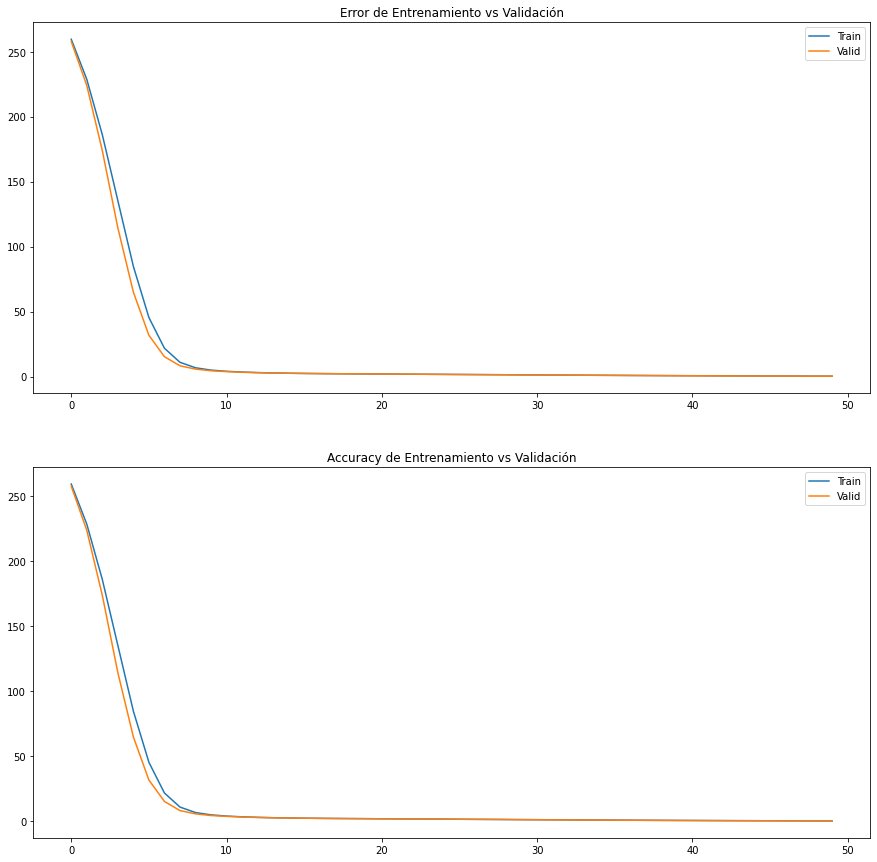

In [146]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history["train_loss"]) 
axs[0].plot(history["valid_loss"]) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])  

axs[1].plot(history["train_acc"]) 
axs[1].plot(history["valid_acc"]) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

In [147]:
pred = model(torch.tensor(train_data.x).float())
pred = pred.detach().numpy()

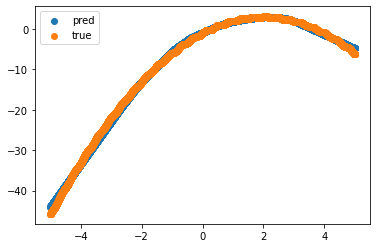

In [148]:

plt.scatter(train_data.x, pred, label='pred')
plt.scatter(train_data.x, train_data.y, label='true')
plt.legend()
plt.show()